## 1 Prepare data

In [177]:
from scipy import stats
import numpy as np
import pandas as pd
import wrangle as wr
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML

#talos items
import talos as ta
from talos.metrics.keras_metrics import fmeasure_acc
from talos import live


# Keras items
from keras import backend as K
from keras.optimizers import Nadam,SGD,RMSprop,Adagrad,Adadelta,Adam,Adamax,Nadam
from keras.activations import relu, elu
from keras.losses import binary_crossentropy
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.models import model_from_json


In [352]:
attrs=[]
attr_types={}
with open('communities.attrs','r') as g:
    attr=g.readline()
    while attr:
        redundant,attr,cat=attr.split()
        if cat not in attr_types:
                attr_types[cat]=set()
        attr_types[cat].add(attr)
        attrs.append(attr)
        attr=g.readline()

A=[]
index=[]
def convert(i):
    try:
        return float(i)
    except:
        return -1.
    
with open("communities.data", "r") as f:
    data=f.readline()
    while data:
        x=data.split(',')
        x[-1]=x[-1][:-1]
        index.append(x[3])
        data=f.readline()
        A.append([convert(i) for i in x])
    
data=pd.DataFrame.from_records(A, index=index, columns=attrs)
display(data.head())
print(data.shape)
#data is dataframe indexed by 'communityname' each enry has 128 numeric entry 
#with ''ViolentCrimesPerPop' be the target of regrssion

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
Lakewoodcity,8.0,-1.0,-1.0,-1.0,1.0,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
Tukwilacity,53.0,-1.0,-1.0,-1.0,1.0,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,-1.00,-1.00,-1.0,-1.0,0.00,-1.00,0.67
Aberdeentown,24.0,-1.0,-1.0,-1.0,1.0,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,-1.00,-1.00,-1.0,-1.0,0.00,-1.00,0.43
Willingborotownship,34.0,5.0,81440.0,-1.0,1.0,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,-1.00,-1.00,-1.0,-1.0,0.00,-1.00,0.12
Bethlehemtownship,42.0,95.0,6096.0,-1.0,1.0,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,-1.00,-1.00,-1.0,-1.0,0.00,-1.00,0.03


(1994, 128)


In [334]:
target='ViolentCrimesPerPop'
x=data.drop(target, 1).values
#normaalize x to have std 1 and mean 0
x = wr.mean_zero(pd.DataFrame(x)).fillna(1).values
y=data[target].values
total=len(data[target])
split=int(total*0.2)
x_test=x[:split]
y_test=y[:split]
x=x[split:]
y=y[split:]
rest_total=len(x)
split=int(rest_total*0.2)
x_val=x[:split]
y_val=y[:split]
x_train=x[split:]
y_train=y[split:]
#split .2 of total data for testing split .2 of rest data for validating rest is for training
len(x_train),len(x_val),len(x_test)

(1277, 319, 398)

In [350]:
print(x_train[0])
print(y)

[ 0.01929857 -0.28533314 -0.67836511  1.         -0.51988205 -0.05983002
  0.83439739 -0.51147346  0.76333517 -0.44849761 -0.49043516  0.55273651
  0.11237814 -0.27785301 -1.52447882 -0.03175065  0.68283272  0.52003883
  1.43153181 -0.6936034   0.1926929  -1.61925846 -0.80031033 -1.36812261
  0.27400313 -0.10596468 -0.3107487   0.51809507  0.22148019  0.34615744
  0.70373755 -0.03429548 -0.27752294 -0.8448399  -1.1052114  -1.15220152
  0.08759836 -0.85833451  1.48777387 -0.3280077  -0.4023596  -0.35804805
 -0.00718774 -0.44526787 -1.05139184 -0.10028958 -0.24112867  0.72610623
  0.88665019  0.96602701  0.85014158  0.71598619  0.99963873  1.10310629
 -0.33397942 -0.8697472  -0.34476848 -0.54868536 -0.76151457 -0.73984461
 -0.50201956 -0.68435073 -0.68600826 -0.69601694 -0.65103956  0.67923459
 -0.50331657 -0.39481565 -0.16722197  1.16719024  1.36503456  0.29531135
  0.79864288 -0.60138081 -1.42129874  0.72617276 -0.24467856  0.46618615
  0.65502865  0.66800404 -0.70552989  1.35857045 -0

## 2. Creating the Keras Model

In [97]:
# first we have to make sure to input data and params into the function
# def breast_cancer_model(x_train, y_train, x_val, y_val, params):

#     model = Sequential()
#     model.add(Dense(params['first_neuron'], input_dim=x_train.shape[1],
#                     activation=params['first_activation'],
#                     kernel_initializer=params['kernel_initializer']))
    
#     model.add(Dense(params['second_neuron'], activation=params['activation']))
#     model.add(Dropout(params['dropout']))

#     model.add(Dense(1, activation=params['last_activation']
#                     ))
    
#     model.compile(loss=params['losses'],
#                   optimizer=params['optimizer'](),
#                   metrics=['acc', fmeasure_acc])
    
#     history = model.fit(x_train, y_train, 
#                         validation_data=[x_val, y_val],
#                         batch_size=params['batch_size'],
#                         callbacks=[live()],
#                         epochs=params['epochs'],
#                         verbose=0)

#     return history, model

def crime_model(x_train, y_train, x_val, y_val, p):
    
    #print("Val size",np.shape(x_val))
    model = Sequential()
    model.add(Dense(p['first_neuron'], input_dim=x_train.shape[1],
                    activation=p['first_activation'],
                    kernel_initializer=p['kernel_initializer']))
    for i in range(p['hidden_layer']):
        model.add(Dense(p['hidden_neuron'], activation=p['activation']))
        Dropout(rate=p['drop_out'])
    #model.add(Dropout(params['dropout']))

    model.add(Dense(1, activation=p['last_activation']
                    ))
    def r_value( y_true,y_pred):###actually returns 1-r
        return 1-K.mean(normalize(y_true)*normalize(y_pred))
    def normalize(x):
        return K.batch_normalization(x,K.mean(x),K.var(x),beta=0,gamma=1)
    model.compile(loss=p['losses'],
                  optimizer=p['optimizers'](lr_normalizer(p['lr'], p['optimizers'])),
                  metrics=[r_value])
    
    history = model.fit(x_train, y_train, 
                        validation_data=(x_val, y_val),
                        callbacks=[live()],
                        epochs=p['epochs'],
                        verbose=0)
   # print("Val size",np.shape(x_val),np.shape(y_val))

    return history, model



In [189]:
# run this code just once
best_param_each_round={}
data_each_round={}
exp_nums=set()

## 3. Defining the Parameter Space Boundary

In [378]:
# set the parameter space
para_spaces={}
#test para space for the first round:
p={
    'first_neuron':[10],
    'first_activation':['relu'],
    'hidden_layer':[3],
     'hidden_neuron':[8],
     'batch_size': [30],
     'epochs': [40],
     'kernel_initializer': ['normal'],
     'optimizers': ['Adam'],
     'losses': ['MSE'],
     'activation':['relu'],
     'last_activation': ['linear'],
    'lr':[1]
  }
para_spaces[1]=p 

#test para space for the second round:
p={
    'first_neuron':[12,18,24],
    'first_activation':['relu','linear'],
    'hidden_layer':[1,2],
     'hidden_neuron':[8],
     'batch_size': [20],
     'epochs': [40],
     'kernel_initializer': ['normal'],
     'optimizers': ['Adam'],
     'losses': ['MSE'],
     'activation':['relu','linear'],
     'last_activation': ['linear'],
    'lr':[1]
  }
para_spaces[2]=p

#test para space for the third round:
p={
    'first_neuron':[24],
    'first_activation':['linear'],
    'hidden_layer':[1,2],
     'hidden_neuron':[8],
     'batch_size': [20],
     'epochs': [40],
     'kernel_initializer': ['normal'],
     'optimizers': ['SGD','RMSprop','Adagrad','Adadelta','Adam','Adamax','Nadam'],
     'losses': ['MSE'],
     'activation':['linear'],
     'last_activation': ['linear'],
    'lr':[1]
  }
para_spaces[3]=p
#test para space for the fourth round:
p={
    'first_neuron':[24],
    'first_activation':['linear'],
    'hidden_layer':[2,3,4],
     'hidden_neuron':[2,4,8],
     'batch_size': [20],
     'epochs': [40],
     'kernel_initializer': ['normal'],
     'optimizers': ['Adam'],
     'losses': ['MSE'],
     'activation':['linear'],
     'last_activation': ['linear'],
    'lr':[1]
  }
para_spaces[4]=p

p={
    'first_neuron':[24],
    'first_activation':['linear'],
    'hidden_layer':[1,2],
     'hidden_neuron':[8,16,24],
     'batch_size': [60],
     'epochs': [120],
     'kernel_initializer': ['normal'],
     'optimizers': ['Adam'],
     'losses': ['MSE'],
     'activation':['linear'],
     'last_activation': ['linear'],
    'lr':[1]
  }
para_spaces[5]=p

p={
    'first_neuron':[24],
    'first_activation':['linear'],
    'hidden_layer':[1],
     'hidden_neuron':[24],
     'batch_size': [120],
     'epochs': [120],
     'kernel_initializer': ['uniform'],
     'optimizers': ['Adam'],
     'losses': ['MSE'],
     'activation':['linear'],
     'last_activation': ['linear'],
    'lr':[1]
  }
para_spaces[6]=p

p={
    'first_neuron':[24],
    'first_activation':['linear'],
    'hidden_layer':[1],
     'hidden_neuron':[24],
     'batch_size': [120],
     'epochs': [120],
     'kernel_initializer': ['uniform'],
     'optimizers': ['SGD'],
     'losses': ['MSE'],
     'activation':['linear'],
     'last_activation': ['linear'],
    'lr':[1,5,10,50,100]
  }
para_spaces[7]=p

p={
    'first_neuron':[24],
    'first_activation':['linear','relu'],
    'hidden_layer':[1],
     'hidden_neuron':[24],
     'batch_size': [120],
     'epochs': [120],
     'kernel_initializer': ['uniform'],
     'optimizers': ['SGD'],
     'losses': ['MSE'],
     'activation':['linear','relu'],
     'last_activation': ['linear'],
    'lr':[5]
  }
para_spaces[8]=p

p={
    'first_neuron':[24],
    'first_activation':['relu'],
    'hidden_layer':[1,2],
     'hidden_neuron':[8],
     'batch_size': [20],
     'epochs': [40],
     'kernel_initializer': ['normal'],
     'optimizers': ['SGD','RMSprop','Adagrad','Adadelta','Adam','Adamax','Nadam'],
     'losses': ['MSE'],
     'activation':['relu'],
     'last_activation': ['linear'],
    'lr':[1]
  }
para_spaces[9]=p

p={
    'first_neuron':[12,24],
    'first_activation':['relu'],
    'hidden_layer':[2],
     'hidden_neuron':[8,16],
     'batch_size': [20],
     'epochs': [80],
     'kernel_initializer': ['normal'],
     'optimizers': ['RMSprop'],
     'losses': ['MSE'],
     'activation':['relu'],
     'last_activation': ['linear'],
    'lr':[1],
    'drop_out':[0,0.1]
  }
para_spaces[10]=p

p={
    'first_neuron':[12,18,24],
    'first_activation':['relu'],
    'hidden_layer':[0,1,2],
     'hidden_neuron':[8,16,24],
     'batch_size': [20,40],
     'epochs': [80],
     'kernel_initializer': ['normal'],
     'optimizers': ['RMSprop'],
     'losses': ['MSE'],
     'activation':['relu'],
     'last_activation': ['linear'],
    'lr':[1],
    'drop_out':[0.1]
  }
para_spaces[11]=p

## 4. Starting the Experiment

In [407]:
exp_round=1
exp_nums.add(exp_round)

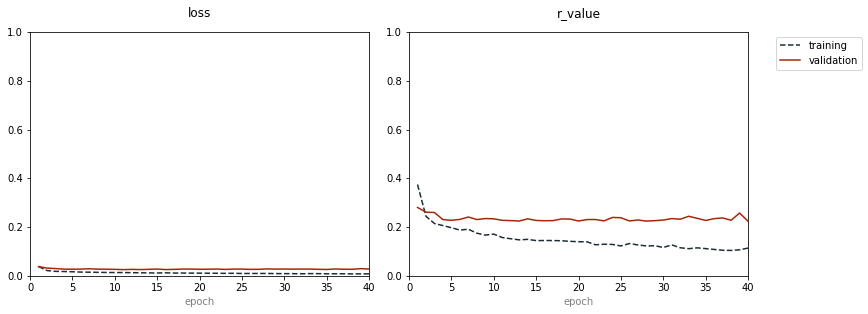























100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:21<00:00, 21.86s/it]

Scan Finished!


,round_epochs,val_loss,val_r_value,loss,r_value,first_neuron,first_activation,hidden_layer,hidden_neuron,batch_size,epochs,kernel_initializer,optimizers,losses,activation,last_activation,lr
0,40,0.0253823741243,0.223628043007,0.007770333725,0.104077048524,10,relu,3,8,30,40,normal,Adam,MSE,relu,linear,1


In [408]:
t = ta.Scan(x=x_train,
            y=y_train,
            model=crime_model,
            params=para_spaces[exp_round],x_val=x_val,y_val=y_val,print_params=False)
t.data

## 5. Predict on valiation data

In [409]:
def best_model(self, metric, asc):

    '''Picks the best model based on a given metric and
    returns the index number for the model.

    NOTE: for loss 'asc' should be True'''

    best = self.data.sort_values(metric, ascending=asc).iloc[0].name

    return best


def activate_model(self, model_id):

    '''Loads the model from the json that is stored in the Scan object'''

    model = model_from_json(self.saved_models[model_id])
    model.set_weights(self.saved_weights[model_id])

    return model
def graph(x, y, x_label="x_label", y_label="y_label", col="blue", savename="default"):
    # Get correlation
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    rsquared = r_value ** 2
    print("r-squared:", rsquared)
    
    # Graph
    fig = plt.figure(figsize=(6, 6))
    fig.suptitle("r-squared = " + str(rsquared), fontsize = 30)
    plt.scatter(x, y, alpha = 0.2, color = col)
    plt.xlabel(x_label, fontsize = 20)
    plt.ylabel(y_label, fontsize = 20)
    plt.savefig(savename + ".png")
    plt.show()
    
def evaluate(model,train_x,train_y,valid_x,valid_y,test_x,test_y):
    graph(test_y, model.predict(test_x).ravel(),'true_test','pred_test')
    graph(valid_y, model.predict(valid_x).ravel(),'true_val','pred_val')
    graph(train_y, model.predict(train_x).ravel(),'true_train','pred_train')


In [410]:
#save result of experiment

#choose the best model by sorting the lowest 1-r_value for the validation and save it
data=ta.Predict(t).scan_object.data.sort_values("val_r_value")
ta.Deploy(t, 'best_crime_model'+str(exp_round),metric='val_r_value',asc=True)

#save all performance of all models in para_space 
data_each_round[exp_round]=data

#sace best parameters for this experiment
r=ta.Reporting(t)
best_param_each_round[exp_round]=r.best_params('val_r_value',ascending=True)[0]


Deploy package best_crime_model1 have been saved.


,round_epochs,val_loss,val_r_value,loss,r_value,first_neuron,first_activation,hidden_layer,hidden_neuron,batch_size,epochs,kernel_initializer,optimizers,losses,activation,last_activation,lr
0,40,0.0253823741243,0.223628043007,0.007770333725,0.104077048524,10,relu,3,8,30,40,normal,Adam,MSE,relu,linear,1


['Adam' '3' 'relu' '30' 'MSE' 'linear' '10' 'normal' '8' 'relu'
 '0.104077048524' '40' '1' 0]
r-squared: 0.546262948541


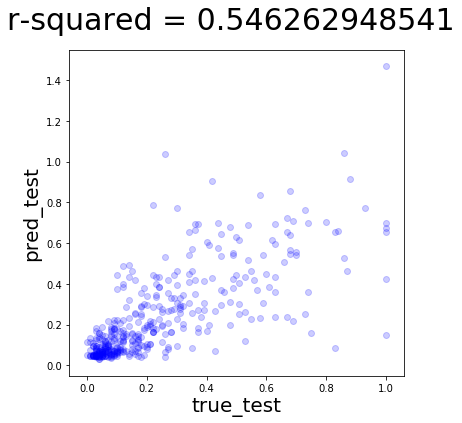

r-squared: 0.625077447952


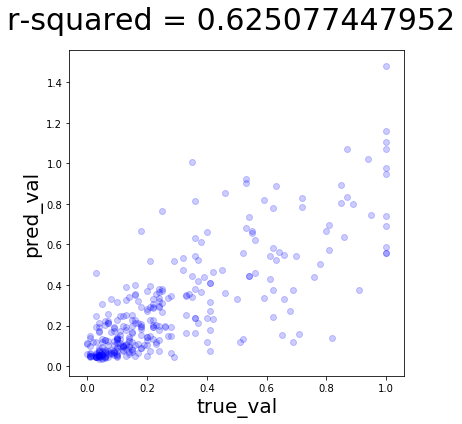

r-squared: 0.862721889663


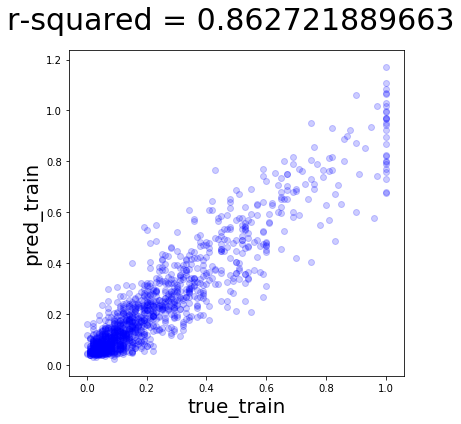

In [411]:
display(data)
print(r.best_params('val_r_value',ascending=True)[0])
#visualize the predict and truth and compute the r_squared
evaluate(activate_model(ta.Predict(t).scan_object, data.index[0]),x_train,y_train,x_val,y_val,x_test,y_test)

## 6. Data analysis

In [403]:
def summary(para_spaces,best_param_each_round,data_each_round,exp_round):
    for i in exp_nums:
        print('experiment ',i)
        print('para_spaces is ')
        print(para_spaces[i])
        print('best parameter in para sapces')
        print(best_param_each_round[i])
        print('data overview')
        display(data_each_round[i].head())

Based on the parameter space of p1 in section 3, we get r_squared 0.45 for train data and 0.37 for validation data. By trying p2, p3,... repeatring section 4 and 5. The log are stated below:


In [404]:
summary(para_spaces,best_param_each_round,data_each_round,exp_round)

experiment  1
para_spaces is 
{'first_neuron': [10], 'first_activation': ['relu'], 'hidden_layer': [3], 'hidden_neuron': [8], 'batch_size': [30], 'epochs': [40], 'kernel_initializer': ['normal'], 'optimizers': ['Adam'], 'losses': ['MSE'], 'activation': ['relu'], 'last_activation': ['linear'], 'lr': [1]}
best parameter in para sapces
['Adam' '3' 'relu' '30' 'MSE' 'linear' '10' 'normal' '8' 'relu'
 '0.32306459021' '40' 0]
data overview


,round_epochs,val_loss,val_r_value,loss,r_value,first_neuron,first_activation,hidden_layer,hidden_neuron,batch_size,epochs,kernel_initializer,optimizers,losses,activation,last_activation
0,40,0.0451811119027,0.401542362375,0.0259917132212,0.32306459021,10,relu,3,8,30,40,normal,Adam,MSE,relu,linear


experiment  2
para_spaces is 
{'first_neuron': [12, 18, 24], 'first_activation': ['relu', 'linear'], 'hidden_layer': [1, 2], 'hidden_neuron': [8], 'batch_size': [20], 'epochs': [40], 'kernel_initializer': ['normal'], 'optimizers': ['Adam'], 'losses': ['MSE'], 'activation': ['relu', 'linear'], 'last_activation': ['linear'], 'lr': [1]}
best parameter in para sapces
['Adam' '1' 'linear' '20' 'MSE' 'linear' '12' 'normal' '8' 'relu'
 '0.247115365303' '40' 0]
data overview


,round_epochs,val_loss,val_r_value,loss,r_value,first_neuron,first_activation,hidden_layer,hidden_neuron,batch_size,epochs,kernel_initializer,optimizers,losses,activation,last_activation
18,40,0.0309726783077,0.264345959997,0.022594296644,0.247115365303,12,linear,1,8,20,40,normal,Adam,MSE,relu,linear
0,40,0.0345281210252,0.291954773347,0.0394494661546,0.294048113289,24,relu,1,8,20,40,normal,Adam,MSE,linear,linear
1,40,0.0411359666669,0.337285018453,0.0329516329157,0.385422130581,24,linear,1,8,20,40,normal,Adam,MSE,relu,linear
22,40,0.0384731232992,0.342935567366,0.0349326671124,0.331281966732,18,relu,2,8,20,40,normal,Adam,MSE,relu,linear
19,40,0.0439319604873,0.394374484552,0.0255768804292,0.309961203961,24,linear,2,8,20,40,normal,Adam,MSE,relu,linear


experiment  3
para_spaces is 
{'first_neuron': [24], 'first_activation': ['linear'], 'hidden_layer': [1, 2], 'hidden_neuron': [8], 'batch_size': [20], 'epochs': [40], 'kernel_initializer': ['normal'], 'optimizers': ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'], 'losses': ['MSE'], 'activation': ['linear'], 'last_activation': ['linear'], 'lr': [1]}
best parameter in para sapces
['Adam' '2' 'linear' '20' 'MSE' 'linear' '24' 'normal' '8' 'linear'
 '0.316725109411' '40' 0]
data overview


,round_epochs,val_loss,val_r_value,loss,r_value,first_neuron,first_activation,hidden_layer,hidden_neuron,batch_size,epochs,kernel_initializer,optimizers,losses,activation,last_activation
6,40,0.0662390453782,0.270107139988,0.0602951224707,0.316725109411,24,linear,2,8,20,40,normal,Adam,MSE,linear,linear
13,40,0.083104676167,0.382664744383,0.0867571717211,0.477262378392,24,linear,1,8,20,40,normal,Adam,MSE,linear,linear
8,40,0.0934257602617,0.472222046792,0.122394551339,0.555499381821,24,linear,1,8,20,40,normal,Nadam,MSE,linear,linear
3,40,0.188478144452,0.493513660184,0.180405597122,0.645941612584,24,linear,2,8,20,40,normal,Nadam,MSE,linear,linear
1,40,0.575373266371,0.660159563944,5.96088932937,0.781431953143,24,linear,2,8,20,40,normal,Adadelta,MSE,linear,linear


experiment  4
para_spaces is 
{'first_neuron': [24], 'first_activation': ['linear'], 'hidden_layer': [2, 3, 4], 'hidden_neuron': [2, 4, 8], 'batch_size': [20], 'epochs': [40], 'kernel_initializer': ['normal'], 'optimizers': ['Adam'], 'losses': ['MSE'], 'activation': ['linear'], 'last_activation': ['linear'], 'lr': [1]}
best parameter in para sapces
['Adam' '2' 'linear' '20' 'MSE' 'linear' '24' 'normal' '8' 'linear'
 '0.533592241578' '40' 0]
data overview


,round_epochs,val_loss,val_r_value,loss,r_value,first_neuron,first_activation,hidden_layer,hidden_neuron,batch_size,epochs,kernel_initializer,optimizers,losses,activation,last_activation
2,40,0.063750469082,0.467068731598,0.0723437313268,0.533592241578,24,linear,2,8,20,40,normal,Adam,MSE,linear,linear
0,40,0.0970723950027,0.548478525634,0.0679361065769,0.65557719948,24,linear,4,8,20,40,normal,Adam,MSE,linear,linear
3,40,0.220545919244,0.572395808271,0.12977265762,0.741778685978,24,linear,2,4,20,40,normal,Adam,MSE,linear,linear
4,40,0.110142510233,0.698888548863,0.105283152939,0.67407336376,24,linear,4,4,20,40,normal,Adam,MSE,linear,linear
8,40,0.0663701061358,0.728026142502,0.0487206812274,0.782344845981,24,linear,3,2,20,40,normal,Adam,MSE,linear,linear


experiment  5
para_spaces is 
{'first_neuron': [24], 'first_activation': ['linear'], 'hidden_layer': [1, 2], 'hidden_neuron': [8, 16, 24], 'batch_size': [60], 'epochs': [120], 'kernel_initializer': ['normal'], 'optimizers': ['Adam'], 'losses': ['MSE'], 'activation': ['linear'], 'last_activation': ['linear'], 'lr': [1]}
best parameter in para sapces
['Adam' '1' 'linear' '60' 'MSE' 'linear' '24' 'normal' '24' 'linear'
 '0.380643290473' '120' 0]
data overview


,round_epochs,val_loss,val_r_value,loss,r_value,first_neuron,first_activation,hidden_layer,hidden_neuron,batch_size,epochs,kernel_initializer,optimizers,losses,activation,last_activation
0,120,0.047020494319,0.294256998267,0.0355444613293,0.380643290473,24,linear,1,24,60,120,normal,Adam,MSE,linear,linear
3,120,0.0364537882476,0.308292591086,0.0358932960542,0.344960830972,24,linear,2,16,60,120,normal,Adam,MSE,linear,linear
1,120,0.0534290392244,0.321607060941,0.0408636321056,0.338916638351,24,linear,1,8,60,120,normal,Adam,MSE,linear,linear
2,120,0.0384618309108,0.342842700713,0.0307686903857,0.362127954314,24,linear,1,16,60,120,normal,Adam,MSE,linear,linear
5,120,0.132363438256,0.347308927943,0.08242343491,0.563277931818,24,linear,2,24,60,120,normal,Adam,MSE,linear,linear


experiment  6
para_spaces is 
{'first_neuron': [24], 'first_activation': ['linear'], 'hidden_layer': [1], 'hidden_neuron': [24], 'batch_size': [120], 'epochs': [120], 'kernel_initializer': ['uniform'], 'optimizers': ['Adam'], 'losses': ['MSE'], 'activation': ['linear'], 'last_activation': ['linear'], 'lr': [1]}
best parameter in para sapces
['Adam' '1' 'linear' '120' 'MSE' 'linear' '24' 'uniform' '24' 'linear'
 '0.26668042724' '120' 0]
data overview


,round_epochs,val_loss,val_r_value,loss,r_value,first_neuron,first_activation,hidden_layer,hidden_neuron,batch_size,epochs,kernel_initializer,optimizers,losses,activation,last_activation
1,120,0.0287966618495,0.243640165531,0.0248541333913,0.26668042724,24,linear,1,24,120,120,uniform,Adam,MSE,linear,linear
3,120,0.0346765869814,0.264232223684,0.0243657209685,0.284735555423,24,linear,1,24,60,120,uniform,Adam,MSE,linear,linear
5,120,0.032595320415,0.280749969348,0.0267761197822,0.301591922598,24,linear,1,24,240,120,normal,Adam,MSE,linear,linear
2,120,0.0626074808028,0.288231928334,0.0379211560574,0.359441952306,24,linear,1,24,120,120,normal,Adam,MSE,linear,linear
0,120,0.0336145159371,0.289435781655,0.0293004278315,0.334580433863,24,linear,1,24,60,120,normal,Adam,MSE,linear,linear


experiment  7
para_spaces is 
{'first_neuron': [24], 'first_activation': ['linear'], 'hidden_layer': [1], 'hidden_neuron': [24], 'batch_size': [120], 'epochs': [120], 'kernel_initializer': ['uniform'], 'optimizers': ['SGD'], 'losses': ['MSE'], 'activation': ['linear'], 'last_activation': ['linear'], 'lr': [1, 5, 10, 50, 100]}
best parameter in para sapces
['SGD' '1' 'linear' '120' 'MSE' 'linear' '24' 'uniform' '24' 'linear'
 '0.168904794831' '120' '5' 0]
data overview


,round_epochs,val_loss,val_r_value,loss,r_value,first_neuron,first_activation,hidden_layer,hidden_neuron,batch_size,epochs,kernel_initializer,optimizers,losses,activation,last_activation,lr
3,120,0.025084335719,0.22004524574,0.0143204978262,0.168904794831,24,linear,1,24,120,120,uniform,SGD,MSE,linear,linear,5
0,120,0.0254841452599,0.220170428387,0.014346076053,0.170756991711,24,linear,1,24,120,120,uniform,SGD,MSE,linear,linear,10
4,120,0.0253452925204,0.222198422987,0.0142141770733,0.165967846159,24,linear,1,24,120,120,uniform,SGD,MSE,linear,linear,1
2,120,0.0252531968221,0.222406622758,0.0143908223658,0.171727976859,24,linear,1,24,120,120,uniform,SGD,MSE,linear,linear,100
1,120,0.0253395033726,0.226972270909,0.0142472141591,0.168327167338,24,linear,1,24,120,120,uniform,SGD,MSE,linear,linear,50


experiment  8
para_spaces is 
{'first_neuron': [24], 'first_activation': ['linear', 'relu'], 'hidden_layer': [1], 'hidden_neuron': [24], 'batch_size': [120], 'epochs': [120], 'kernel_initializer': ['uniform'], 'optimizers': ['SGD'], 'losses': ['MSE'], 'activation': ['linear', 'relu'], 'last_activation': ['linear'], 'lr': [5]}
best parameter in para sapces
['SGD' '1' 'relu' '120' 'MSE' 'linear' '24' 'uniform' '24' 'relu'
 '0.100950217564' '120' '5' 0]
data overview


,round_epochs,val_loss,val_r_value,loss,r_value,first_neuron,first_activation,hidden_layer,hidden_neuron,batch_size,epochs,kernel_initializer,optimizers,losses,activation,last_activation,lr
0,120,0.0245196609743,0.217671318114,0.00759615258262,0.100950217564,24,relu,1,24,120,120,uniform,SGD,MSE,relu,linear,5
3,120,0.0248305435325,0.220577054823,0.00902326229723,0.116075699369,24,relu,1,24,120,120,uniform,SGD,MSE,linear,linear,5
1,120,0.0264434536458,0.222163432444,0.00752946459772,0.0989694904796,24,linear,1,24,120,120,uniform,SGD,MSE,relu,linear,5
2,120,0.0256527630922,0.222911345361,0.0143476336802,0.169026364175,24,linear,1,24,120,120,uniform,SGD,MSE,linear,linear,5


experiment  9
para_spaces is 
{'first_neuron': [24], 'first_activation': ['relu'], 'hidden_layer': [1, 2], 'hidden_neuron': [8], 'batch_size': [20], 'epochs': [40], 'kernel_initializer': ['normal'], 'optimizers': ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'], 'losses': ['MSE'], 'activation': ['relu'], 'last_activation': ['linear'], 'lr': [1]}
best parameter in para sapces
['RMSprop' '2' 'relu' '20' 'MSE' 'linear' '24' 'normal' '8' 'relu'
 '0.0680969849451' '40' '1' 0]
data overview


,round_epochs,val_loss,val_r_value,loss,r_value,first_neuron,first_activation,hidden_layer,hidden_neuron,batch_size,epochs,kernel_initializer,optimizers,losses,activation,last_activation,lr
3,40,0.0241364643889,0.209316112592,0.00457238626649,0.0680969849451,24,relu,2,8,20,40,normal,RMSprop,MSE,relu,linear,1
0,40,0.0244199473201,0.212301848077,0.00801769469973,0.101826652149,24,relu,2,8,20,40,normal,Adamax,MSE,relu,linear,1
10,40,0.0261619951763,0.226911972122,0.00447899391605,0.0683190225621,24,relu,2,8,20,40,normal,Adam,MSE,relu,linear,1
4,40,0.0259850755929,0.228241824244,0.0037091588276,0.0628777652302,24,relu,2,8,20,40,normal,Nadam,MSE,relu,linear,1
2,40,0.025651745358,0.229497847512,0.00578543648908,0.0828773719124,24,relu,1,8,20,40,normal,Adadelta,MSE,relu,linear,1


experiment  10
para_spaces is 
{'first_neuron': [12, 24], 'first_activation': ['relu'], 'hidden_layer': [2], 'hidden_neuron': [8, 16], 'batch_size': [20], 'epochs': [80], 'kernel_initializer': ['normal'], 'optimizers': ['RMSprop'], 'losses': ['MSE'], 'activation': ['relu'], 'last_activation': ['linear'], 'lr': [1], 'drop_out': [0, 0.1]}
best parameter in para sapces
['RMSprop' '2' 'relu' '20' 'MSE' 'linear' '12' 'normal' '8' 'relu'
 '0.0702105683093' '0.1' '80' '1' 0]
data overview


,round_epochs,val_loss,val_r_value,loss,r_value,first_neuron,first_activation,hidden_layer,hidden_neuron,batch_size,epochs,kernel_initializer,optimizers,losses,activation,last_activation,lr,drop_out
4,80,0.0232833070523,0.205629448158,0.00476843640777,0.0702105683093,12,relu,2,8,20,80,normal,RMSprop,MSE,relu,linear,1,0.1
5,80,0.0250093584653,0.214622877421,0.00245791338408,0.047977873564,24,relu,2,8,20,80,normal,RMSprop,MSE,relu,linear,1,0.1
3,80,0.0250975988852,0.214897029265,0.00262521966047,0.0486624484988,24,relu,2,8,20,80,normal,RMSprop,MSE,relu,linear,1,0
6,80,0.0251669969094,0.219272874739,0.00411406264512,0.0633183478749,12,relu,2,16,20,80,normal,RMSprop,MSE,relu,linear,1,0.1
7,80,0.0252912953718,0.220436518282,0.00221732452427,0.0420253657697,24,relu,2,16,20,80,normal,RMSprop,MSE,relu,linear,1,0


experiment  11
para_spaces is 
{'first_neuron': [12, 18, 24], 'first_activation': ['relu'], 'hidden_layer': [0, 1, 2], 'hidden_neuron': [8, 16, 24], 'batch_size': [20, 40], 'epochs': [80], 'kernel_initializer': ['normal'], 'optimizers': ['RMSprop'], 'losses': ['MSE'], 'activation': ['relu'], 'last_activation': ['linear'], 'lr': [1], 'drop_out': [0.1]}
best parameter in para sapces
['RMSprop' '2' 'relu' '20' 'MSE' 'linear' '18' 'normal' '8' 'relu'
 '0.0537643317795' '0.1' '80' '1' 0]
data overview


,round_epochs,val_loss,val_r_value,loss,r_value,first_neuron,first_activation,hidden_layer,hidden_neuron,batch_size,epochs,kernel_initializer,optimizers,losses,activation,last_activation,lr,drop_out
45,80,0.0242788373116,0.20771109161,0.00317980389394,0.0537643317795,18,relu,2,8,20,80,normal,RMSprop,MSE,relu,linear,1,0.1
13,80,0.0249641558336,0.210531750443,0.00661566519866,0.0887642710491,12,relu,0,16,20,80,normal,RMSprop,MSE,relu,linear,1,0.1
15,80,0.0248270633814,0.213825010768,0.00340094739176,0.0543501585745,12,relu,2,16,20,80,normal,RMSprop,MSE,relu,linear,1,0.1
14,80,0.0270790904644,0.2150657276,0.00506985911585,0.0722150196764,18,relu,0,8,20,80,normal,RMSprop,MSE,relu,linear,1,0.1
16,80,0.0276024212074,0.216186226909,0.00523445350479,0.0717132476129,24,relu,0,16,40,80,normal,RMSprop,MSE,relu,linear,1,0.1


## 7 Final model

r-squared: 0.55046154821


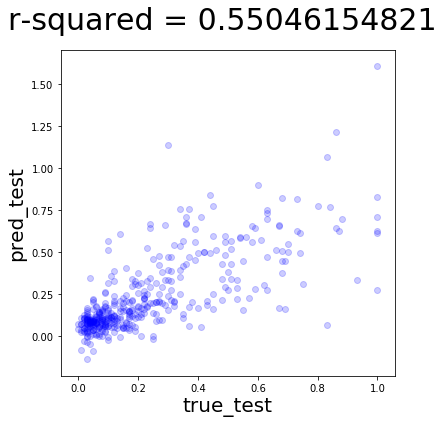

r-squared: 0.527460649744


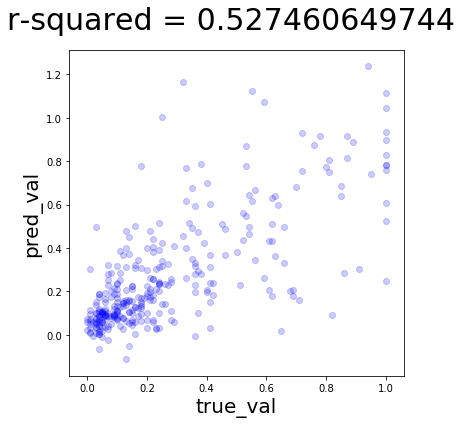

r-squared: 0.91532865235


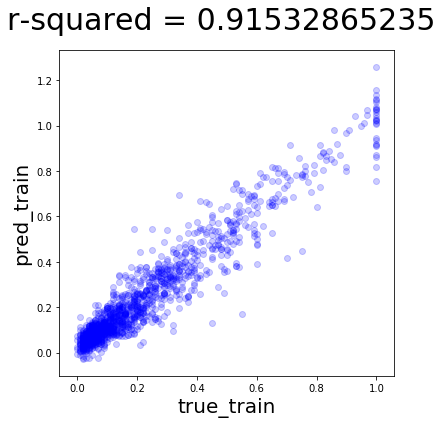

In [406]:
re = ta.Restore('best_crime_model10.zip')
evaluate(re.model,x_train,y_train,x_val,y_val,x_test,y_test)